In [1]:
import os
import sys
import json
from datetime import datetime

import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

In [4]:
# Add the `src` folder to the Python path
sys.path.append(os.path.join(os.path.abspath('..'), 'src'))
import environment_gym as env_gym
import environment_gym_rs1 as env_gym_rs1
import utilities as util

# Load the TensorBoard extension
# %reload_ext tensorboard

## Reward Shaping Method 1

Penality applied to not switching to faster adjacent lanes for 3 consecutive timesteps

### Train PPO Model 2

In [6]:
# Initialize and vectorize the environment
env = env_gym_rs1.TrafficEnvironment(reward_shaping_flag=True)
check_env(env, warn=True)
env.reset()
eval_env = Monitor(env_gym_rs1.TrafficEnvironment(reward_shaping_flag=False))

# Set up log directory
log_dir = "./logs/ppo_rs1_model/"
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = PPO(policy = "MlpPolicy",
            device = "cpu",    # PPO is meant to be run primarily on the CPU 
            env = env, 
            verbose = 1,
            tensorboard_log = log_dir
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the PPO model
total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo_rs_model/PPO_2
Eval num_timesteps=1000, episode_reward=-22292.00 +/- 23646.68
Episode length: 1753.00 +/- 1576.53
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.75e+03  |
|    mean_reward     | -2.23e+04 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-11964.00 +/- 15882.62
Episode length: 1064.40 +/- 1058.77
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1.06e+03 |
|    mean_reward     | -1.2e+04 |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 626       |
|    ep_rew_mean     | -8.62e+03 |
| ti

In [ ]:
# Start TensorBoard to monitor logs
# %tensorboard --logdir ./logs/ppo_rs1_model/ --port=5000

### Test Model 2

In [ ]:
# Load the best baseline model
log_dir = "./logs/ppo_rs1_model/"
model_path = log_dir + 'best_model/best_model.zip'
model = PPO.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [ ]:
# Test the model
num_episodes = 1000
file_name = 'ppo_rs1_best_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

### Analysis of Model 2

Average reward of 1000 episodes is -6790.
Average timesteps of 1000 episodes is 1068.


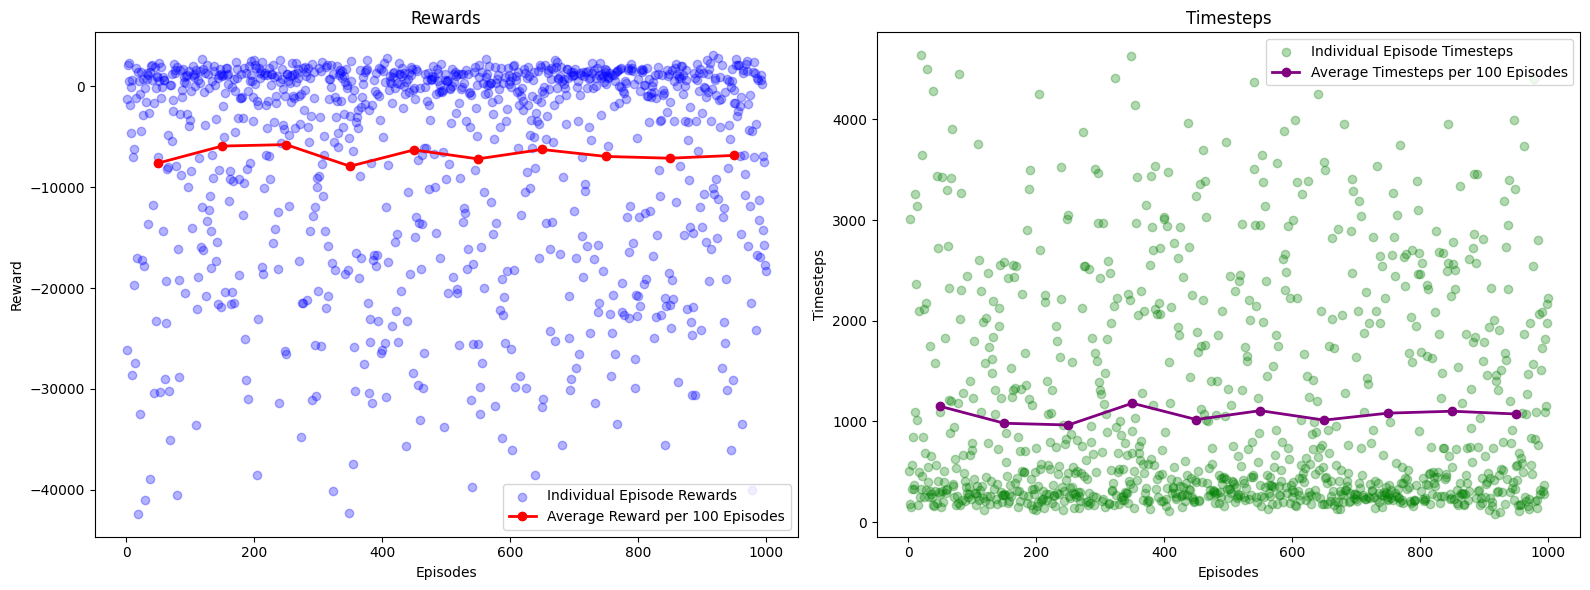

In [10]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=100)

In [11]:
util.calculate_action_percentages(log_file=file_name)
print("")
util.calculate_clearance_rate_percentages(log_file=file_name)

Total actions across 1000 episodes: 1067676
Action -1: 0.0%
Action 0: 97.9%
Action 1: 2.1%

Total timesteps across 1000 episodes (including initial states): 1068676
Lane 1:
  77.0% of timesteps had a clearance rate less than 5
  87.7% of timesteps had a clearance rate less than 10
Lane 2:
  76.5% of timesteps had a clearance rate less than 5
  87.5% of timesteps had a clearance rate less than 10
Lane 3:
  76.4% of timesteps had a clearance rate less than 5
  87.2% of timesteps had a clearance rate less than 10
Lane 4:
  76.6% of timesteps had a clearance rate less than 5
  87.0% of timesteps had a clearance rate less than 10
Lane 5:
  77.0% of timesteps had a clearance rate less than 5
  87.2% of timesteps had a clearance rate less than 10


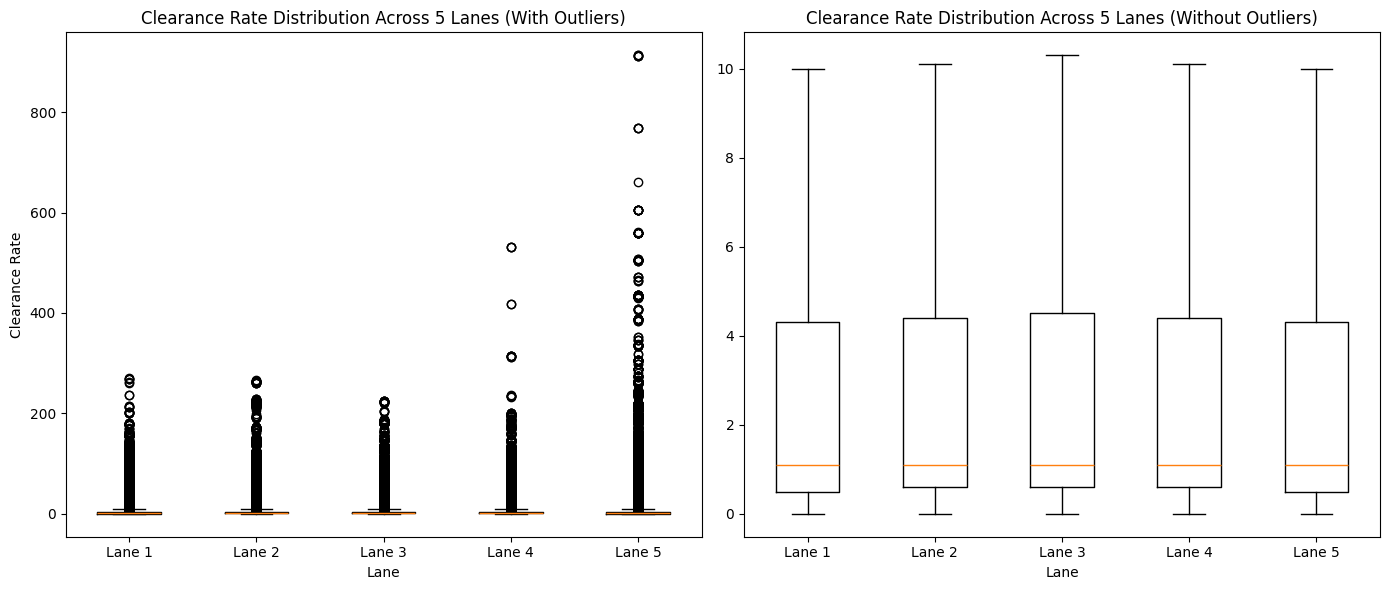

In [12]:
util.plot_clearance_rate_boxplots(log_file=file_name)

### Train Model 3 (Fine-tune Model 2)

In [20]:
# Initialize and vectorize the environment
env = env_gym_rs.TrafficEnvironment(reward_shaping_flag=True)
check_env(env, warn=True)
env.reset()
eval_env = Monitor(env_gym_rs.TrafficEnvironment(reward_shaping_flag=False))

# Set up log directory
log_dir = "./logs/ppo_rs1_finetune_model/"
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = PPO(policy = "MlpPolicy",
            device = "cpu",    # PPO is meant to be run primarily on the CPU 
            env = env,
            learning_rate=0.0005,
            ent_coef=0.01,
            gamma = 0.98,
            n_epochs=20,
            clip_range=0.3,
            verbose = 1,
            tensorboard_log = log_dir
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the PPO model
total_timesteps = 100000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo_rs_finetune_model/PPO_1


Eval num_timesteps=1000, episode_reward=-4554.00 +/- 7374.53
Episode length: 855.40 +/- 737.45
----------------------------------
| eval/              |           |
|    mean_ep_length  | 855       |
|    mean_reward     | -4.55e+03 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-10444.00 +/- 13759.56
Episode length: 1444.40 +/- 1375.96
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.44e+03  |
|    mean_reward     | -1.04e+04 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
-----------------------------
| time/              |      |
|    fps             | 272  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
Eval num_timesteps=3000, episode_reward=-16631.00 +/- 19677.62
Episode length: 1375.

### Test Reward Shaping Model 2

In [ ]:
# Load the best baseline model
log_dir = "./logs/ppo_rs1_finetune_model/"
model_path = log_dir + 'best_model/best_model.zip'
model = PPO.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [ ]:
# Test the model
num_episodes = 100
file_name = 'ppo_rs1_finetune_best_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

### Analysis of Reward Shaping Model 2

Average reward of 100 episodes is -6159.
Average timesteps of 100 episodes is 1016.


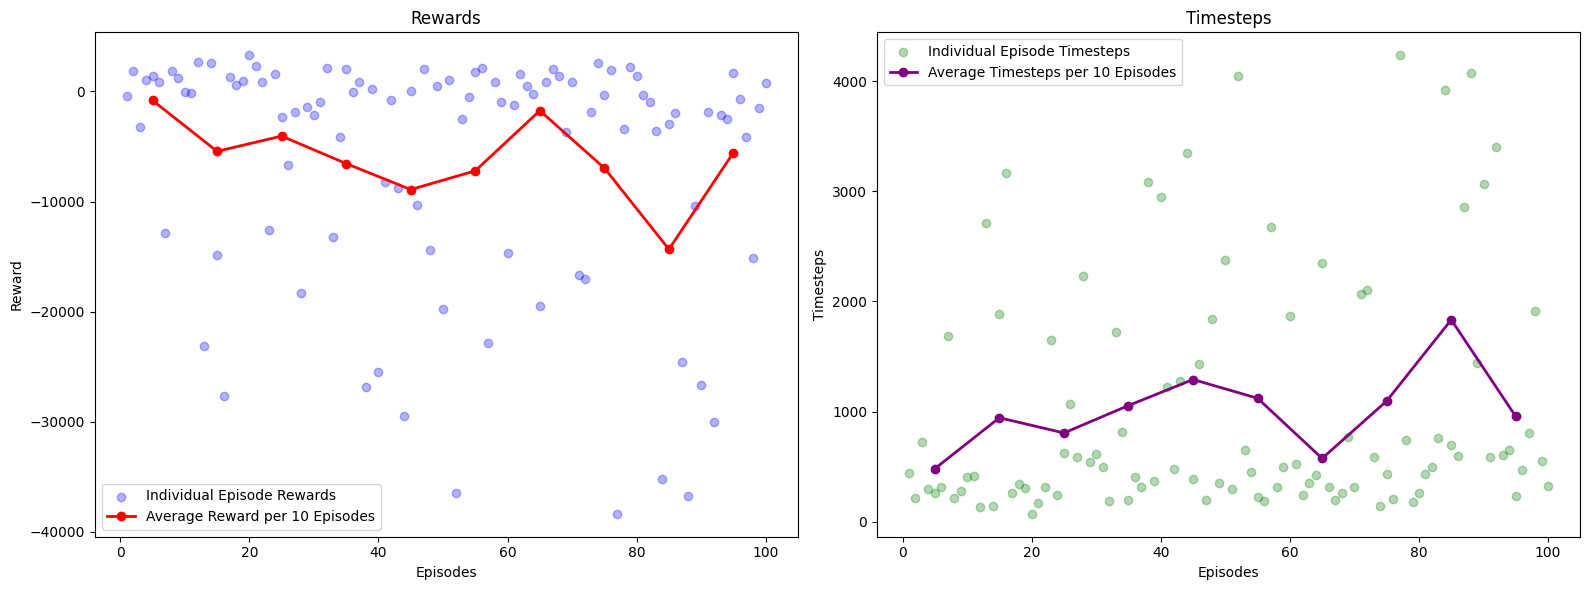

In [23]:
util.plot_test_results(rewards=rewards, timesteps=timesteps, interval=10)

Total actions across 100 episodes: 101588
Action -1: 0.0%
Action 0: 100.0%
Action 1: 0.0%

Total timesteps across 100 episodes (including initial states): 101688
Lane 1:
  75.1% of timesteps had a clearance rate less than 5
  87.1% of timesteps had a clearance rate less than 10
Lane 2:
  74.6% of timesteps had a clearance rate less than 5
  87.1% of timesteps had a clearance rate less than 10
Lane 3:
  74.6% of timesteps had a clearance rate less than 5
  86.0% of timesteps had a clearance rate less than 10
Lane 4:
  74.7% of timesteps had a clearance rate less than 5
  86.1% of timesteps had a clearance rate less than 10
Lane 5:
  74.9% of timesteps had a clearance rate less than 5
  86.3% of timesteps had a clearance rate less than 10


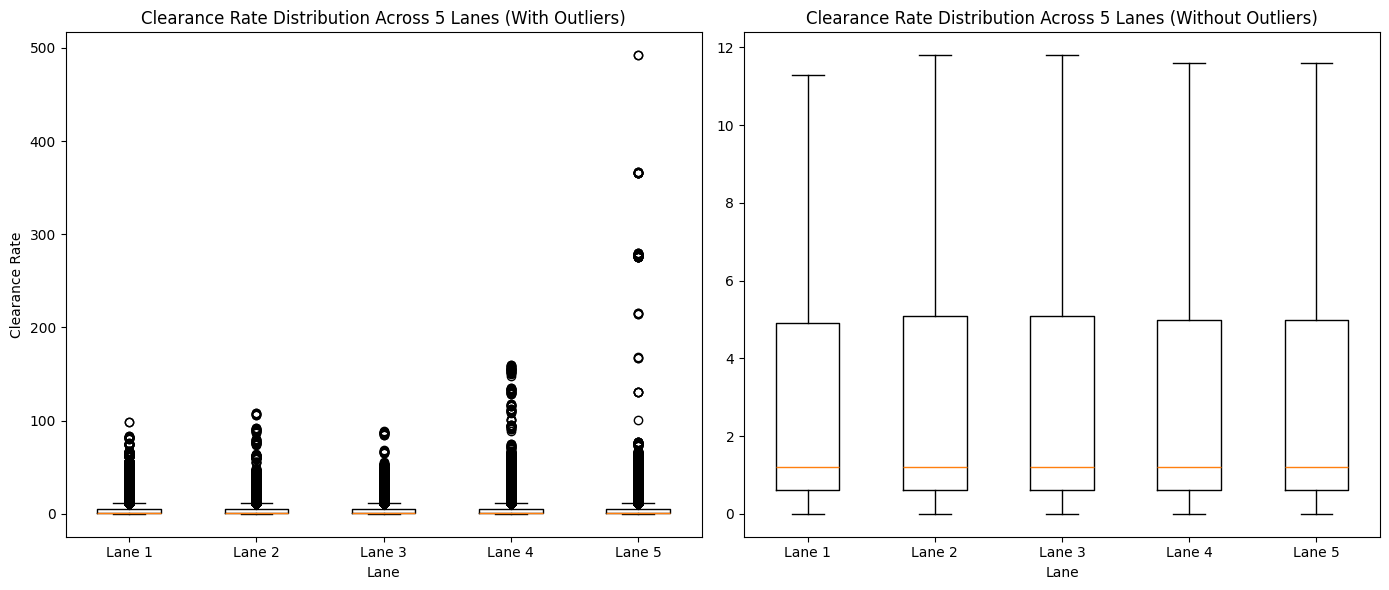

In [24]:
util.calculate_action_percentages(log_file=file_name)
print("")
util.calculate_clearance_rate_percentages(log_file=file_name)
util.plot_clearance_rate_boxplots(log_file=file_name)